# (Arabic) Recipe 5-5. Clustering Documents

### import libraries

In [2]:
# import numpy as np

import pandas as pd
import nltk
from nltk.stem.snowball import SnowballStemmer

#from bs4 import BeautifulSoup

import re

#import os
#import codecs

from sklearn import feature_extraction

#import mpld3

from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

#import matplotlib as mpl

from sklearn.manifold import MDS

### import data

In [3]:
Data = pd.read_csv("arabic_dataset_classifiction.csv", encoding='utf-8')

dataset source : [DataSet for Arabic Classification](https://data.mendeley.com/datasets/v524p5dhpj/2) <br>
it is collected from 3 Arabic online newspapers: Assabah, Hespress and Akhbarona using semi-automatic web crawling process.

### Data understanding

In [4]:
Data.head()

,text,targe
0,بين أستوديوهات ورزازات وصحراء مرزوكة وآثار ولي...,0
1,قررت النجمة الأمريكية أوبرا وينفري ألا يقتصر ع...,0
2,أخبارنا المغربية الوزاني تصوير الشملالي ألهب ا...,0
3,اخبارنا المغربية قال ابراهيم الراشدي محامي سعد...,0
4,تزال صناعة الجلود في المغرب تتبع الطريقة التقل...,0


In [5]:
Data.rename(columns={"targe": "Target", "text": "Text"}, inplace = True)

In [6]:
Data.head()

,Text,Target
0,بين أستوديوهات ورزازات وصحراء مرزوكة وآثار ولي...,0
1,قررت النجمة الأمريكية أوبرا وينفري ألا يقتصر ع...,0
2,أخبارنا المغربية الوزاني تصوير الشملالي ألهب ا...,0
3,اخبارنا المغربية قال ابراهيم الراشدي محامي سعد...,0
4,تزال صناعة الجلود في المغرب تتبع الطريقة التقل...,0


In [7]:
Data.shape

(111728, 2)

In [8]:
Data['Target'].unique()

array([0, 1, 2, 3, 4], dtype=int64)

In [9]:
Data.dtypes

Text      object
Target     int64
dtype: object

In [10]:
Data[Data['Target'] == 0].Text.iloc[350]

'قالت إنها انتظرت خمس سنوات لتشارك في فد تي في قالت الفنانة بديعة الصنهاجي التي تتقمص دور عبلة في سيتكوم ديما جيران على شاشة القناة الثانية إن قلة أعمالها التلفزيونية راجعة إلى عدم تفكيرها في الاحتراف بعد تخرجها من معهد الفن المسرحي والتنشيط الثقافي وأضافت بديعة في تصريح الصباح أن دراستها المسرح لمدة سبع سنوات كانت من باب الهواية مشيرة إلى أنها ركزت أثناء دراستها على تجسيد أدوار باللغة الفرنسية لمسرحيات كلاسيكية لموليير وتشيكوف وكان أول ظهور لبديعة الصنهاجي على شاشة التلفزيون رفقة المخرج نور الدين لخماري في السلسلة البوليسية القضية »، التي تولى بعض أصدقائها مهمة اقتراحها للعمل فيها وأوضحت الصنهاجي بخصوص دورها في سلسلة القضية أنه من الشخصيات التي تعتز بتقمصها رغم أنه من الأدوار الثانوية مضيفة أن بحكم وظيفتها لم يكن ممكنا بالنسبة إليها الغياب لمدة طويلة عن العمل إن احتراف الفن أمر صعب وهذا ما جعلني بعيدة لعدة سنوات عنه كما أن ارتباطي بعملي في مجالي التسويق والاتصال في مجال الوكالات العقارية ساهم في ذلك »، تقول بديعة عن أسباب تأخرها في دخول المجال الفني وأكدت بديعة أنها من المعجبات بأداء 

by observing the content, i realized that the labels are represntative of the following <br>
- 0 celebrities <br>
- 1 crimes <br>
- 2 economy <br>
- 3 politics <br>
- 4 sports

In [11]:
categories = {
              0 : 'celebrities', 
              1 : 'crimes', 
              2 : 'economy', 
              3 : 'politics', 
              4 : 'sports'
             }

In [12]:
# Selecting non null data
Data = Data[pd.notnull(Data['Text'])]

In [13]:
Data.shape

(108789, 2)

In [14]:
Data.groupby('Target').Text.count().sort_values(ascending=False)

Target
4    43675
3    20485
1    16728
2    14165
0    13736
Name: Text, dtype: int64

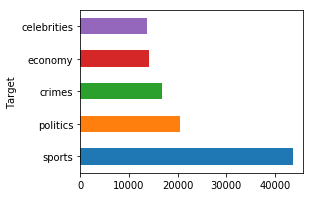

In [15]:
# Lets plot it and see

import matplotlib.pyplot as plt

fig = plt.figure(figsize=(4,3))
Data.groupby('Target').Text.count().sort_values(ascending=False).plot(kind='barh') # for each product, how many complaints
ax = plt.gca()

labels = []
for item in ax.get_yticklabels():
    labels.append(categories[int(item.get_text())])
ax.set_yticklabels(labels) # note below
plt.show()

- **note:** in the previous cell, i couldnot just make `ax.set_yticklabels(categories.values())` b/c the order of the label in the returned list (from the previous instruction) will be different than the actual order of labels that should be shown on the plot
    - note that this mismatch of labels happens due to the sorting operation in the previous cell

In [16]:
# lets do the clustering for just 200 documents. Its easier to interpret.
# i will take 200/5 = 40 samples from each class 

sample_1 = Data[Data['Target'] == 0].sample(n=40)
sample_2 = Data[Data['Target'] == 1].sample(n=40)
sample_3 = Data[Data['Target'] == 2].sample(n=40)
sample_4 = Data[Data['Target'] == 3].sample(n=40)
sample_5 = Data[Data['Target'] == 4].sample(n=40)


# Here we recreate a 'balanced' dataset.
Data_sample = pd.concat([sample_1, sample_2, sample_3, sample_4, sample_5],axis=0)
Data_sample.reset_index(drop=True, inplace=True)

In [17]:
Data_sample.shape

(200, 2)

### Preprocessing 

In [18]:
# remove stop words
from nltk.corpus import stopwords
stop = stopwords.words('arabic')

Data_sample['Text'] = Data_sample['Text'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))

In [19]:
# remove punctuation and multiple spaces

import re

pattern_punctuation = '[^a-zA-z0-9ء-ي\s]' # for punctuation (not numeric nor arabic nor english letters)
pattern_multi_spaces = '[ ]{2,}'

Data_sample['Text'] = Data_sample['Text'].apply(lambda x: re.sub(pattern_punctuation, '' , x))
Data_sample['Text'] = Data_sample['Text'].apply(lambda x: re.sub(pattern_multi_spaces, ' ' , x))

In [20]:
# stemming 

# Load 'stemmer'
stemmer = SnowballStemmer("arabic")
Data_sample['Text'] = Data_sample['Text'].apply(lambda sentence: ' '.join([stemmer.stem(word) for word in sentence.split()]))

### TF-IDF feature engineering

In [37]:
# Convert dataframe to list
news = Data_sample['Text'].tolist()

# create the rank of documents – we will use it later
ranks = [i for i in range(1, len(news)+1)] # a list from 1 to 200



                                                   
from sklearn.feature_extraction.text import TfidfVectorizer

# tfidf vectorizer
tfidf_vectorizer = TfidfVectorizer( analyzer='word', 
                                    max_df=0.8, max_features=200000, \
                                    min_df=0.2, \
                                    token_pattern=r'\w{1,}', \
                                    ngram_range=(1,3))

#fit the vectorizer to data
tfidf_matrix = tfidf_vectorizer.fit_transform(news)
terms = tfidf_vectorizer.get_feature_names() #features
print(tfidf_matrix.shape)                                         

(200, 57)


200 example, each will go through an equation of for 57 (parameters)/ features /(n-grams)

### Clustering using K-means

In [24]:
#Import Kmeans
from sklearn.cluster import KMeans

# Define number of clusters
num_clusters = 5

#Running clustering algorithm
km = KMeans(n_clusters=num_clusters)
km.fit(tfidf_matrix)

#final clusters
clusters = km.labels_.tolist()
news_data = { 'rank': ranks, 'news': news, 'cluster': clusters }
frame = pd.DataFrame(news_data, index = [clusters], columns = ['rank', 'cluster'])

#number of docs per cluster
frame['cluster'].value_counts()

4    66
3    49
1    44
2    21
0    20
Name: cluster, dtype: int64

In [27]:
frame['cluster'].unique()


array([2, 1, 4, 0, 3], dtype=int64)

In [30]:
len(km.labels_)

200

In [40]:
len(km.cluster_centers_)

5

In [42]:
len(km.cluster_centers_[0])

57

each cluster center is a vector of dimension 57. let's look at them

In [41]:
km.cluster_centers_

array([[0.03248527, 0.02189102, 0.04954796, 0.04621247, 0.01531446,
        0.03022352, 0.07606406, 0.02664715, 0.02883105, 0.05435795,
        0.06404077, 0.00560683, 0.09533807, 0.06541311, 0.06912338,
        0.03910158, 0.0169257 , 0.06106175, 0.07461952, 0.06513898,
        0.05394055, 0.1850029 , 0.02201267, 0.03945411, 0.        ,
        0.03032348, 0.09973852, 0.        , 0.41345487, 0.02322707,
        0.03085142, 0.01148653, 0.06736626, 0.03685044, 0.01441734,
        0.03196861, 0.00794861, 0.01935987, 0.01604061, 0.0436571 ,
        0.0624836 , 0.07886131, 0.08163429, 0.05336237, 0.07973041,
        0.05532229, 0.07107651, 0.07633935, 0.06417358, 0.00691475,
        0.14456835, 0.05150122, 0.03151827, 0.03111549, 0.0313129 ,
        0.06412423, 0.11365917],
       [0.04213921, 0.08225302, 0.1011664 , 0.03242434, 0.04521476,
        0.05325476, 0.05498726, 0.04789464, 0.03317994, 0.05134117,
        0.09187863, 0.07956282, 0.17473456, 0.0562845 , 0.01347864,
        0.02942

### Identify cluster behavior

Identify which are the top 5 words that are nearest to the cluster centroid.

In [180]:
import numpy as np

def euclidean_distance(u, v):
    return np.linalg.norm(u - v)


def idx_top_n_nearest_points_to_centroid(idx_points, points_matrix, centroid, n):
    num_examples = points_matrix.shape[0]
    distances = []
    for i in range(num_examples): # in range(200)
        dist = 100000# very large number so that the elements that does not belong to the class is not considered as near points
        if i in idx_points:
            dist = euclidean_distance(points_matrix[i], centroid)
        distances.append(dist)
    
    sorted_distances = distances.copy()
    sorted_distances.sort()
        
    indices_of_nearst_points= []
    for i in range(n):
        indices_of_nearst_points.append(distances.index(sorted_distances[0]))
        sorted_distances.pop(0)
        
    return indices_of_nearst_points
        

In [181]:
def idx_points_of_class(class_value, labels):
    indices = []
    for i in range(len(labels)):
        if labels[i] == class_value:
            indices.append(i)
    
    return indices

In [197]:
for i in range(num_clusters): 
    
    class_idx_points = idx_points_of_class(i, km.labels_)
    idx_nearest_example  = idx_top_n_nearest_points_to_centroid(class_idx_points, tfidf_matrix, km.cluster_centers_[i], 1)
        
    print('top word in top document in class ', i)
    
    # top word in the nearest example
    dense = tfidf_matrix[idx_nearest_example].toarray()
    nearest_example = list(tfidf_matrix[idx_nearest_example].toarray()[0])
    idx_of_top_word = nearest_example.index(max(nearest_example))

    print(tfidf_vectorizer.get_feature_names()[idx_of_top_word])
        
    print()
    print()


top word in top doc in class  0
دور


top word in top doc in class  1
انه


top word in top doc in class  2
مجموع


top word in top doc in class  3
مغرب


top word in top doc in class  4
رييس




### Plot the clusters on a 2D graph

In [124]:
# import moduls for appropriate arabic text plotting with matplotlib
import arabic_reshaper
from bidi.algorithm import get_display

D:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


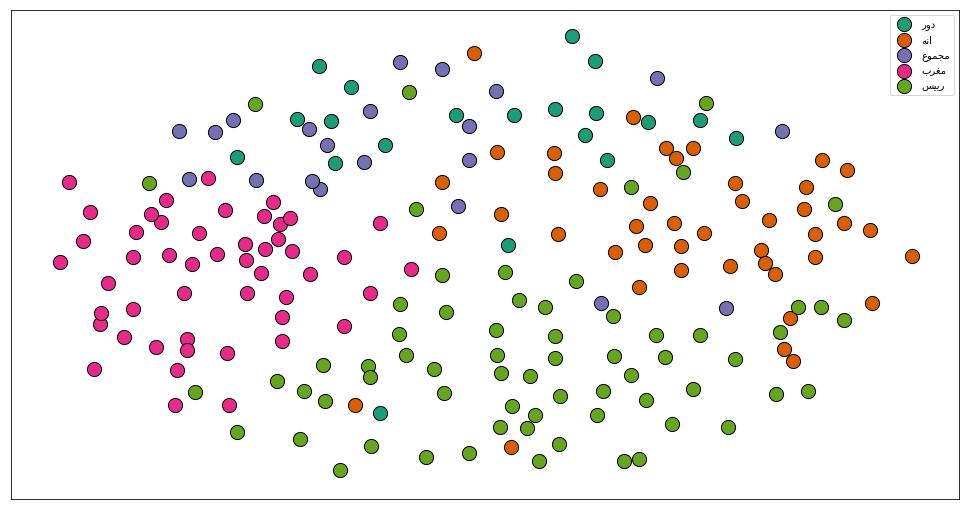

In [198]:
#Similarity
similarity_distance = 1 - cosine_similarity(tfidf_matrix)

# Convert two components as we're plotting points in a two-dimensional plane
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)
pos = mds.fit_transform(similarity_distance) # shape (n_components, n_samples)
xs, ys = pos[:, 0], pos[:, 1]

#Set up colors per clusters using a dict
cluster_colors = {0: '#1b9e77', 1: '#d95f02', 2: '#7570b3', 3: '#e7298a', 4: '#66a61e', 5: '#D2691E'}

#set up cluster names using a dict
cluster_names = {0: get_display(arabic_reshaper.reshape('دور')), 
                 1: get_display(arabic_reshaper.reshape('انه')), 
                 2: get_display(arabic_reshaper.reshape('مجموع')), 
                 3: get_display(arabic_reshaper.reshape('مغرب')),
                 4: get_display(arabic_reshaper.reshape('رييس'))}

# Finally plot it
%matplotlib inline

#Create data frame that has the result of the MDS and the cluster
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters))
groups = df.groupby('label')

# Set up plot
fig, ax = plt.subplots(figsize=(17, 9)) # set size

for name, group in groups:
    ax.scatter(group.x, group.y, marker='o', s=200,  label=cluster_names[name], color=cluster_colors[name], edgecolors= 'k')
    
ax.set_aspect('auto')
ax.tick_params( axis= 'x', which='both', bottom='off', top='off', labelbottom='off')
ax.tick_params(axis= 'y', which='both', left='off', top='off', labelleft='off')
ax.legend(numpoints=1)
plt.show()

That’s it. I have clustered 200 complaints into 5 groups using
K-means clustering. I can also use the word embeddings and solve this
to achieve better clusters. 2D graphs provide a good look into the cluster's
behavior and if we look, we will see that the same color dots (docs) are
located closer to each other.

### further iterations for improvement:
- try differnet n-grams and different options for the tfidf
- try to apply spelling correction before converting the words to features
- use different feature representation
    - bag of words
    - word embeddings
    - character embeddings